In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
from PIL import Image, ImageDraw
import os

In [3]:
model_path = '/content/mnist_cnn_model.keras'

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

if os.path.exists(model_path):
  print("Loading saved model...")
  model = tf.keras.models.load_model(model_path)
else:
  print("Model not found. Training a new model...")
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
  )

  model.fit(datagen.flow(train_images, train_labels, batch_size=64),
            epochs=5,
            validation_data=(test_images, test_labels),
            callbacks=[early_stopping])

  model.save(model_path)
  print("Model trained and saved.")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Loading saved model...


In [4]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9882 - loss: 0.0363
Test Loss: 0.028464721515774727
Test Accuracy: 0.9901999831199646


In [ ]:
def prog_linear(start, end):
  return np.arange(start, end)

def fn_objective(ind1, ind2, operation):
  return operation(ind1, ind2)

def occlude_with_square(img, dim, step, i1, i2, obj_function):
  if min(img.shape[0], img.shape[1]) < dim:
    raise ValueError(f'dim ({dim}) is greater than num_cols ({img.shape[1]}) AND/OR num_rows ({img.shape[0]})')

  img_with_probs = np.zeros(img.shape)

  TEMP_max = -1 # TODO: REMOVE
  TEMP_i = () # TODO: REMOVE

  for y in range(0, img.shape[0] - dim + 1, step):
    for x in range(0, img.shape[1] - dim + 1, step):
      img_occluded = np.copy(img)
      img_occluded[y : y + dim, x : x + dim] = 0
      probabilities = model.predict(img_occluded.reshape(1, 28, 28, 1), verbose=0)[0]
      class_prob_dict = {i: p for i, p in enumerate(probabilities) if i == i1 or i == i2}
      occluded_value = obj_function(class_prob_dict[i1], class_prob_dict[i2])
      if occluded_value > TEMP_max:
        TEMP_max = occluded_value
        TEMP_i = (y, x)
      img_with_probs[y : y + dim, x : x + dim] += occluded_value
  # img_with_probs -= np.mean(img_with_probs)  # TODO: maybe return this back????
  return img_with_probs

def occlude(img, start, end, fn_prog, step, i1, i2, obj_function):
  occlusion_sizes = fn_prog(start, end)
  total_steps = 0
  for dim in occlusion_sizes:
    num_steps = ((img.shape[0] - dim) // step + 1) ** 2
    total_steps += num_steps
  img_all_occlusions = np.zeros((*img.shape, len(occlusion_sizes)))
  for i, dim in enumerate(occlusion_sizes):
    num_steps = ((img.shape[0] - dim) // step + 1) ** 2
    current_steps = sum(((img.shape[0] - occlusion_sizes[k]) // step + 1) ** 2 for k in range(i))
    progress = (current_steps / total_steps) * 100
    print(f'{progress:.1f}%')
    img_all_occlusions[:, :, :, i] = occlude_with_square(img, dim, step, i1, i2, obj_function)
  occlusions_2d = np.sum(img_all_occlusions, axis = -1)
  return occlusions_2d

0.0%
28.1%
54.1%
78.0%


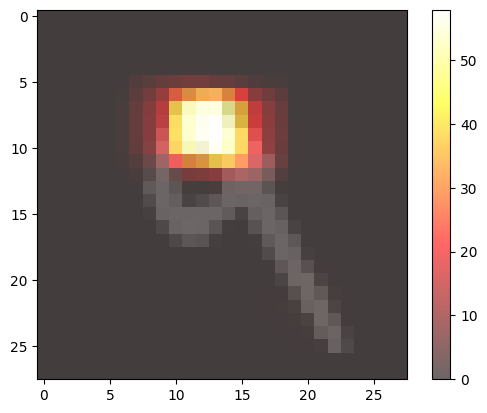

In [ ]:
tf.get_logger().setLevel('ERROR')


for idx, label in enumerate(test_labels[::-1]):
  if label == 9:
    test_image = test_images[idx]
    break
start_dim = test_image.shape[0] // 8
end_dim = test_image.shape[0] // 4
progression_function = prog_linear
step_size = 1
i1 = 4
i2 = 9
comparison_temp = model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)[0]
comparison = comparison_temp[i1] / comparison_temp[i2]
obj_function = lambda v1, v2 : (v1 / v2) - comparison

img_illustrate = occlude(test_image, start_dim, end_dim, progression_function, step_size, i1, i2, obj_function)

plt.imshow(test_image, cmap='gray', alpha=0.4)
plt.imshow(img_illustrate, cmap='hot', alpha=0.6)
plt.colorbar()
plt.show()

0.0%
28.1%
54.1%
78.0%


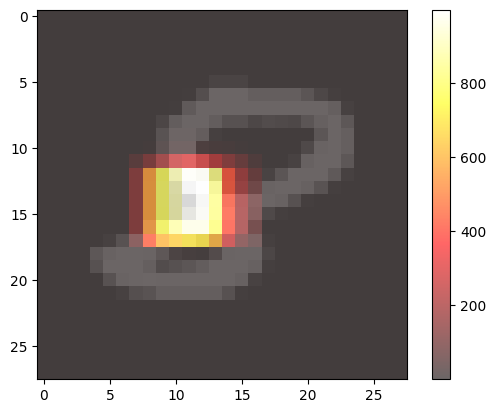

In [ ]:
tf.get_logger().setLevel('ERROR')


for idx, label in enumerate(test_labels):
  if label == 8:
    test_image = test_images[idx]
    break
start_dim = test_image.shape[0] // 8
end_dim = test_image.shape[0] // 4
progression_function = prog_linear
step_size = 1
i1 = 3
i2 = 8
comparison_temp = model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)[0]
comparison = comparison_temp[i1] - comparison_temp[i2]
# obj_function = lambda v1, v2 : (v1 - v2) - comparison
obj_function = lambda v1, v2 : v1 / v2

img_illustrate = occlude(test_image, start_dim, end_dim, progression_function, step_size, i1, i2, obj_function)

plt.imshow(test_image, cmap='gray', alpha=0.4)
plt.imshow(img_illustrate, cmap='hot', alpha=0.6)
plt.colorbar()
plt.show()

In [ ]:
tf.get_logger().setLevel('ERROR')

for idx, label in enumerate(test_labels):
  if label == 9:
    test_image = test_images[idx]
    break
start_dim = test_image.shape[0] // 10
end_dim = test_image.shape[0] // 2
progression_function = prog_linear
step_size = 1
i1 = 4
i2 = 9
comparison_temp = model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)[0]
comparison = comparison_temp[i1] - comparison_temp[i2]
# obj_function = lambda v1, v2 : (v1 - v2) - comparison
obj_function = lambda v1, v2 : v1

img_illustrate = occlude(test_image, start_dim, end_dim, progression_function, step_size, i1, i2, obj_function)

0.0%


KeyboardInterrupt: 

In [ ]:
plt.imshow(test_image, cmap='gray', alpha=0.4)
plt.imshow(img_illustrate, cmap='hot', alpha=0.6)
plt.colorbar()
plt.show()

In [ ]:
for idx, label in enumerate(test_labels):
  if label == 8:
    test_image = test_images[idx]
    break
start_dim = test_image.shape[0] // 8
end_dim = test_image.shape[0] // 4
progression_function = prog_linear
step_size = 1
i1 = 3
i2 = 8
comparison_temp = model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)[0]
comparison = comparison_temp[i1] - comparison_temp[i2]
# obj_function = lambda v1, v2 : (v1 - v2) - comparison
obj_function = lambda v1, v2 : v1

img_illustrate = occlude(test_image, start_dim, end_dim, progression_function, step_size, i1, i2, obj_function)

0.0%
28.1%
54.1%
78.0%


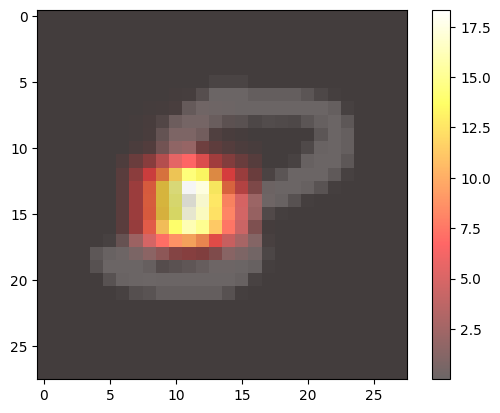

In [ ]:
plt.imshow(test_image, cmap='gray', alpha=0.4)
plt.imshow(img_illustrate, cmap='hot', alpha=0.6)
plt.colorbar()
plt.show()

In [ ]:
for idx, label in enumerate(test_labels):
  if label == 7:
    test_image = test_images[idx]
    break
start_dim = test_image.shape[0] // 10
end_dim = test_image.shape[0] // 2
progression_function = prog_linear
step_size = 1
i1 = 1
i2 = 7
comparison_temp = model.predict(test_image.reshape(1, 28, 28, 1), verbose=0)[0]
comparison = comparison_temp[i1] - comparison_temp[i2]
# obj_function = lambda v1, v2 : (v1 - v2) - comparison
obj_function = lambda v1, v2 : v1

img_illustrate = occlude(test_image, start_dim, end_dim, progression_function, step_size, i1, i2, obj_function)

In [ ]:
plt.imshow(test_image, cmap='gray', alpha=0.4)
plt.imshow(img_illustrate, cmap='hot', alpha=0.6)
plt.colorbar()
plt.show()